In [15]:

import pickle
import os
import scipy
from scipy import stats
import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
import xarray as xr
import datetime
import matplotlib.dates as mdates

from numpy import errstate,isneginf,array
import yaml

import seaborn as sns
import cmocean as cm            # really nice colorbars
import matplotlib.pyplot as plt # for making plots

In [2]:
global_vars = yaml.safe_load(open('../config.yml', 'r') )

#This has custom functions - log transform
%run './00_custom_functions.ipynb'
#more functions for flux conversions
%run './00_co2_flux_equations.ipynb'

In [3]:
data_folder_root = global_vars['download_folder']
final_result_folder = global_vars['hpd_save_folder']

In [4]:
# select end year here so that the code works even when extending
endyear = 2023
endyearmon = 202312

In [5]:
# processed_start_yearmonth = '1982-01'  
processed_end_yearmonth = '2023-12'   
processed_start_yearmonth_back_in_time = '1959-01'  

#this is just the year rather than above is yearmonth
# processed_start_year = '1982'
processed_end_year = '2023'  
processed_start_year_back_in_time = '1959' 

In [7]:
#can load unfilled or filled version of HPD here
#filled means coastal regions that did not have a value assigned in our ML have been filled with a scaled version of Landschutzer et al 2020 climatology, scaled with HPD product.
#method is similar to what is done with SeaFlux, Fay et al. 2021 and Gregor et al. 2021

#load in our most recent product
final_result_folder = global_vars['hpd_save_folder']

ds = xr.load_dataset(f"{final_result_folder}/GCB_2024/HPD_pCO2_cc2000s_1x1_recon_1959-2023.nc")
hpd = ds['HPD_pCO2_back_in_time'] #tehcnically this is in fco2!

ds = xr.load_dataset(f'{final_result_folder}/GCB_2024/HPD_pCO2_cc2000s_1x1_recon_1959-2023_filled.nc') 
hpd_filled = ds['HPD_filled'] #tehcnically this is in fco2!



### Flux needs:
atm fco2
solubility
ice
sst
sal
mslp
winds

In [10]:


# SSS from E4.2.2 (Jan 1959 - end)
SSS = xr.open_dataset(f"{data_folder_root}/SSS/processed/SSS_Met-Office-Hadley-Centre_EN422f-g10-analyses_195901-{endyearmon}.nc")
sss = SSS.sss.sel(time=slice("01-01-1959",f"12-31-{endyear}"))

# SST from ERA5 (Jan 1958-end)
SST = xr.open_dataset(f"{data_folder_root}/SST/processed/SST_ECMWF_ERA5-monthly-reanalysis-1x1-SST_195901-{endyearmon}.nc")
sst = SST.sst_era5.sel(time=slice("01-01-1959",f"12-31-{endyear}"))


# Ice from Hadley (starts in Jan 1870 and can get updated versions at https://www.metoffice.gov.uk/hadobs/hadisst/data/download.html to extend)
ICE = xr.open_dataset(f"{data_folder_root}/Ice/processed/HadISST_ice_1x1_195901-{endyearmon}.nc")
ice = ICE.sic.sel(time=slice("01-01-1959",f"12-31-{endyear}"))



In [11]:
# Wind and MSLP from ERA5:
#updated through 2023 and it is saved as: /data/artemis/observations/ERA5/processed/ERA5_MSLP_WS10_1x1_mon_1958-2023.nc this was done before
#Im trying to update with new code in the data folder root but I cant get it to download right now
era5 = xr.open_dataset(f'/data/artemis/observations/ERA5/processed/ERA5_MSLP_WS10_1x1_mon_1958-{endyear}.nc')

                      
era5 = era5.sel(time=slice("01-01-1959",f"12-31-{endyear}"))
mslp = era5.mslp / 100 # Pascals to hPa
wind = era5.ws10

#note that these all have values over land also. just fyi


In [12]:
wsf = xr.open_dataset(f'/data/artemis/observations/ERA5/processed/ERA5_WS_STD_1x1_mon_1958-2022.nc') #get previous years from file
wind_std_start = wsf.ws_std.sel(time=slice("01-01-1959",f"12-31-2022"))
#need std from earlier years to load in
ds = xr.open_dataset(f"{data_folder_root}/Wind/processed/Wind_ECMWF_ERA5-monthly-10m-uv-wind-1x1_202301-202312.nc")
wind_std_extra = ds.ws_std

wind_std_start = wind_std_start.rename({'lat': 'ylat','lon': 'xlon'})#rename to be consistent with prior work


wind_std = xr.concat([wind_std_start,wind_std_extra],"time")


del wind_std_extra, wind_std_start    


('time', 'ylat', 'xlon')
(780, 180, 360)


In [13]:
# MSLP from ERA5 made by manada in 2024                      
SLP = xr.open_dataset(f"{data_folder_root}/SLP/processed/SLP_ECMWF_ERA5-monthly-reanalysis-1x1-MSLP_195901-202312.nc")                       
mslp2 = SLP.mslp# / 100 # already in hPa

In [16]:
# Atmospheric fCO2

atmos = xr.open_dataset(f"{data_folder_root}/xCO2/processed/global_monthly_pco2_fco2_1959-2023_195901-202312.nc") 
fCO2_air_uatm = atmos.atm_fco2


### Calculate fluxes

In [18]:
%run 00_co2_flux_equations.ipynb

In [19]:
kw_esst = calc_kw(wind, wind_std, sst, ice) #units of cm/hr

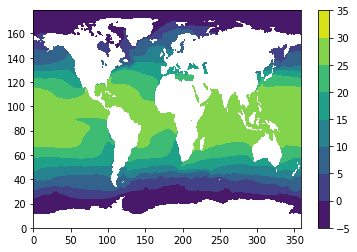

In [20]:
fig = plt.figure()
plt.contourf(np.mean(sst,axis=0))
plt.colorbar()

In [23]:
K0blk = calc_k0_weiss1974(sss, sst+273.15, mslp/1013.25)  # units of mol/L/atm

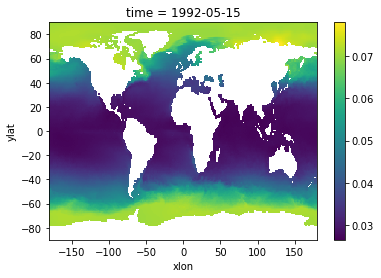

In [24]:
K0blk[400,:,:].plot()

In [26]:
date_range_start = f'1959-01-01T00:00:00.000000000'
date_range_end = f'2023-12-31T00:00:00.000000000'
# create date vector
dates = pd.date_range(start=date_range_start,end=date_range_end,freq='MS') + np.timedelta64(14, 'D')

In [28]:
# Create DataSet that can be used for all other flux calculations!

# Dont need to resave every time if it hasnt changed.



ds_flux_prep = xr.Dataset({'K0':(['time','lat','lon'],K0blk),
                           'kw':(['time','lat','lon'],kw_esst),
                           'ws10':(['time','lat','lon'],wind),
                           'ws10_std':(['time','lat','lon'],wind_std),
                           'sss':(['time','lat','lon'],sss),
                           'sst':(['time','lat','lon'],sst),
                           'ice':(['time','lat','lon'],ice),
                           'slp':(['time','lat','lon'],mslp/1013.25), #convert from hPa to atm
                           'atmos_fco2':(['time','lat','lon'],fCO2_air_uatm),
                           # 'mauna_fco2':(['time','lat','lon'],mauna_fCO2_air_uatm),
                           # 'carbo_scope_pco2':(['time','lat','lon'],pCO2_air_cs),
                           'time':(['time'],dates),
                           'lat':(['lat'],wind.ylat),
                           'lon':(['lon'],wind.xlon)})

ds_flux_prep['K0'].attrs['name'] = "solubility"
ds_flux_prep['K0'].attrs['units'] = "mol/L/atm"
ds_flux_prep['kw'].attrs['units'] = "cm/hr"
ds_flux_prep['atmos_fco2'].attrs['units'] = "mu atm"
# ds_flux_prep['mauna_fco2'].attrs['units'] = "mu atm"
# ds_flux_prep['carbo_scope_pco2'].attrs['units'] = "mu atm"
# ds_flux_prep['kw'].attrs['more_info'] = "ice fraction not used here for kw calculation"
ds_flux_prep['sst'].attrs['units'] = "deg C (ERA5)"
ds_flux_prep['ws10'].attrs['units'] = "m/s (ERA5)"
ds_flux_prep['slp'].attrs['units'] = "atmospheres (ERA5)"
# ds_flux_prep.attrs['more_info'] = "ERA5 for wind, MSLP, & SST, Hadley Ice; E4.2.2 for SSS; created by prep_gas_transfer.ipynb"
ds_flux_prep.attrs['more_info'] = "ERA5 for wind, MSLP, & SST, Hadley Ice; E4.2.2 for SSS; created by 07_calculate_flux.ipynb"
ds_flux_prep.attrs['more_info2'] = "Note: not all variables have land masked out"   
# ds_flux_prep.to_netcdf("/data/artemis/workspace/afay/LDEO_HPD/data_for_flux/ERA5_K0_kw_atmos_pco2_1959-2022.nc")
ds_flux_prep.to_netcdf(f'{final_result_folder}+/variables_needed_for_flux_calc_1959-2023.nc/)




## Calcuate fluxes

In [29]:
#load in the file that is saved above and use those variables to calcluate flux.
ds = xr.open_dataset(f'{final_result_folder}+/variables_needed_for_flux_calc_1959-2023.nc')

In [30]:
#bring in the HPD method saved previously

ds1 = xr.load_dataset(f"{final_result_folder}/GCB_2024/HPD_pCO2_cc2000s_1x1_recon_1959-2023.nc")
hpd = ds1['HPD_pCO2_back_in_time'] #tehcnically this is in fco2!

ds1 = xr.load_dataset(f'{final_result_folder}/GCB_2024/HPD_pCO2_cc2000s_1x1_recon_1959-2023_filled.nc') 
hpd_filled = ds1['HPD_filled'] #technically this is in fco2!


In [33]:
# calculate ice weighting (fraction)
ice_weighting = 1 - ds.ice.fillna(0)
# solubility (mol/L/atm) need to convert to mol/m3/uatm (by dividing by 1000 because 0.001m^3 in 1L and 10^6uatm in 1atm) 
# and kw needs converted from (cm/hr) to (m/yr) by multiplying by 87.6
coef_convert = 87.6/1000



In [37]:
#calculate delta fco2 (ocean minus atm)
delta_hpd = hpd_filled - ds.atmos_fco2.sel(time=slice(str(processed_start_yearmonth_back_in_time),str(processed_end_yearmonth))) 

In [38]:
flux_hpd = ds.K0 * ds.kw * delta_hpd * ice_weighting * coef_convert # mol/m2/yr

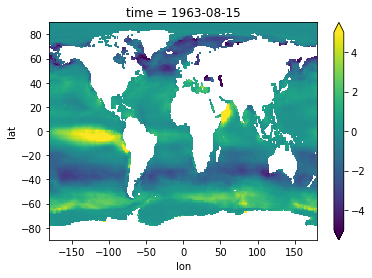

In [39]:
flux_hpd[55,:,:].plot(vmin=-5,vmax=5)

In [42]:
#import mask of open ocean from RECCAP project
#info here: https://reccap2-ocean.github.io/regions/
#full github here: https://github.com/RECCAP2-ocean/R2-shared-resources/tree/master

import requests

# url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
url = 'https://github.com/RECCAP2-ocean/R2-shared-resources/raw/master/data/regions/RECCAP2_region_masks_all_v20221025.nc'
r = requests.get(url, allow_redirects=True)

open('mask.nc', 'wb').write(r.content)
reccap_mask = xr.open_dataset('mask.nc')

#if we would need to rename, but we dont
# reccap_mask = reccap_mask.rename({'latitude': 'lat','longitude': 'lon'})#rename to be consistent with prior work

#replace longitude from 0-360 to -180 to 180
reccap_mask['lon'] = list(map(lambda x: x-360 if x>180 else x, reccap_mask['lon'].values))
# Sort by longitude
reccap_mask = reccap_mask.sortby('lon')

In [51]:
from xarray import register_dataarray_accessor


def earth_radius(lat):
    from numpy import deg2rad, sin, cos

    lat = deg2rad(lat)
    a = 6378137
    b = 6356752
    r = (
        ((a ** 2 * cos(lat)) ** 2 + (b ** 2 * sin(lat)) ** 2)
        / ((a * cos(lat)) ** 2 + (b * sin(lat)) ** 2)
    ) ** 0.5

    return r

def area_grid(lat, lon, return_dataarray=False):
    """Calculate the area of each grid cell for a user-provided
    grid cell resolution. Area is in square meters, but resolution
    is given in decimal degrees.
    Based on the function in
    https://github.com/chadagreene/CDT/blob/master/cdt/cdtarea.m
    """
    from numpy import meshgrid, deg2rad, gradient, cos

    ylat, xlon = meshgrid(lat, lon)
    R = earth_radius(ylat)

    dlat = deg2rad(gradient(ylat, axis=1))
    dlon = deg2rad(gradient(xlon, axis=0))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))

    area = dy * dx

    if not return_dataarray:
        return area
    else:
        from xarray import DataArray

        xda = DataArray(
            area.T,
            dims=["lat", "lon"],
            coords={"lat": lat, "lon": lon},
            attrs={
                "long_name": "area_per_pixel",
                "description": "area per pixel",
                "units": "m^2",
            },
        )
        return xda

In [ ]:
area_tmp = area_grid(flux_hpd.lat,flux_hpd.lon)
area_tmp.shape

(360, 180)

In [53]:
area = xr.DataArray(area_tmp.transpose(), coords=dict( lat=flux_hpd.lat, lon=flux_hpd.lon), dims=["lat", "lon"]) #make a dataarray of the area

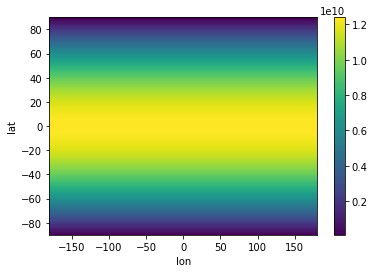

In [54]:
area.plot()

In [55]:
del area_tmp

In [43]:
flux_tmp = flux_hpd * area *12 # g/yr
flux_hpd_global = flux_tmp.where(reccap_mask['seamask']>=1).sum(['lat','lon'])
#annual fluxes
flux_hpd_global_annual = flux_hpd_global.groupby("time.year").mean("time")

In [68]:
#need to save flux here
#save in a format we usually use (where flux values are negative for example)
#use a different code to save for GCB specifically

# Write to file:
co2_out = xr.Dataset({
                        'CO2_flux':(["year"],flux_hpd_global_annual/(10**15)),
                        # 'CO2cc':(["year"],flux_hpdclim/(10**15)),
                        'fgco2':(["time","lat","lon"],flux_hpd),
                        # 'fgco2_cc':(["time","lat","lon"],co2_clim)},
                                },
                        coords={'year':(['year'],range(1959,2024)),
                               'time':(['time'],flux_hpd.time),
                               'lat':(['lat'],flux_hpd.lat),
                               'lon':(['lon'],flux_hpd.lon)})
        
# Save to netcdf
co2_out['CO2_flux'].attrs['description'] = "CO2 Flux, climatology of correction (2000-2023) used for fCO2 prior to 1982"
co2_out['CO2_flux'].attrs['units'] = "PgC/yr"
# co2_out['CO2cc'].attrs['description'] = "CO2 Flux, climatology of correction used for pCO2 ENTIRE TIME"
# co2_out['CO2cc'].attrs['units'] = "PgC/yr"
co2_out['fgco2'].attrs['description'] = "CO2 Flux density, climatology of correction (2000-2023) used for fCO2 prior to 1982"
co2_out['fgco2'].attrs['units'] = "molC/m2/yr"
# co2_out['fgco2_cc'].attrs['description'] = "CO2 Flux, Climatology of correction used for pCO2 ENTIRE TIME"
# co2_out['fgco2_cc'].attrs['units'] = "molC/m2/yr"
co2_out.attrs['title']="LDEO-HPD Clim Correct 2000-2023"
co2_out.attrs['notes']="all values are now fCO2 (rather than pCO2)"
co2_out.attrs['notes']="HPD method now based on 10 models from GCB2024"
co2_out.attrs['history']="XGBoost results and Clim Corrections by AFay, based on code from LGloege, VBennington, DSemant"
co2_out.attrs['institution']="Lamont Doherty Earth Observatory at Columbia"
co2_out.attrs['references']="/home/afay/LDEO_HPD/devans_code/07_calculate_flux.ipynb"
co2_out.attrs['date_created']=str(datetime.datetime.now())
co2_out.to_netcdf(f'{final_result_folder}/GCB_2024/LDEO_HPD_backintime_1x1_flux_1959-2023.nc') 
    